# Comparative analysis between Differential Evolution Clustering and Expectation-Maximization

In [1]:
import DEC.standard_dec as sdec
import DEC.distributed_dec as ddec
import EM.expectation_maximization as em
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import time

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
%matplotlib inline

In [2]:
DATA_DIR = "data"
N_ITER = 5
N_PARTITIONS = 4

ddec.N_ITER = N_ITER
ddec.N_PARTITIONS = N_PARTITIONS

## Runing Distributed Differential Evolution Clustering

In [3]:
Xd, yd = ddec.load_dataset('gs://p2-2020-data/data/2d-20000i-5c.dat', delimiter=' ')

In [4]:
start_ddec_time = time.time()
ddec_preds = ddec.differential_clustering_distributed(Xd)
ddec_time = time.time() - start_ddec_time

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


## Running Standard Differential Evolution Clustering

In [5]:
X, y = sdec.load_custom_data(os.path.join(DATA_DIR, '2d-20000i-5c.dat'))

Iteration: 1


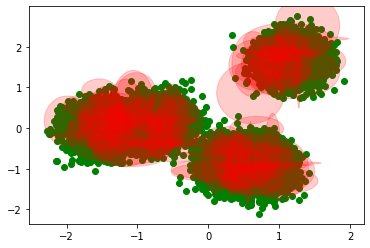

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
ARI: 0.6171707905946202


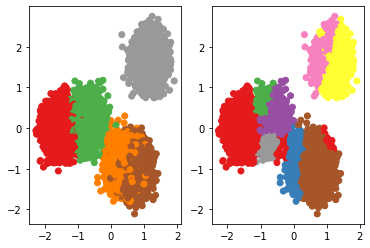

In [6]:
scaler = StandardScaler()

scaler.fit(X)

start_sdec_time = time.time()
sdec_preds = sdec.differential_clustering(scaler.transform(X), y, N_ITER, crowding=True, smart_init=False, wait_on_plots=False, verbose=True)
sdec_time = time.time() - start_sdec_time

## Running Gaussian Mixture

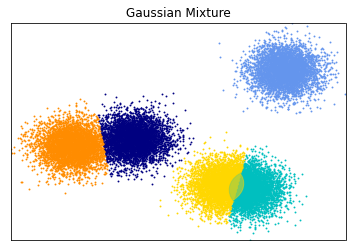

In [7]:
start_em_time = time.time()
gm = em.gaussian_mixture(X, n_clusters=y.max()+1)
em_preds = gm.predict(X)
em_time = time.time() - start_em_time
em.plot_results(X, em_preds, gm.means_, gm.covariances_, 'Gaussian Mixture')

In [8]:
for alg, predictions, y_ in [('EM', em_preds, y), ('DEC', sdec_preds, y), ('Distributed DEC', ddec_preds, yd)]:
    # each cluster contains only members of a single class.
    print(f"Homogeneity score - {alg}:", metrics.homogeneity_score(y_, predictions))
    
    # all members of a given class are assigned to the same cluster.
    print(f"Completeness score - {alg}:", metrics.completeness_score(y_, predictions))
    
    # harmonic mean between homogeneity score and completness score
    print(f"V score - {alg}:", metrics.v_measure_score(y_, predictions))
    
    # measures the similarity of the two assignments
    print(f"ARI - {alg}:", metrics.adjusted_rand_score(y_, predictions))
    print("")

Homogeneity score - EM: 0.8222315864813344
Completeness score - EM: 0.8222765873018278
V score - EM: 0.8222540862758732
ARI - EM: 0.7835579910331271

Homogeneity score - DEC: 0.7835945290253585
Completeness score - DEC: 0.7127916967786705
V score - DEC: 0.7465180637176172
ARI - DEC: 0.6171707905946202

Homogeneity score - Distributed DEC: 0.6321624158643229
Completeness score - Distributed DEC: 0.7674983364073632
V score - Distributed DEC: 0.6932874294398292
ARI - Distributed DEC: 0.5158120810963321



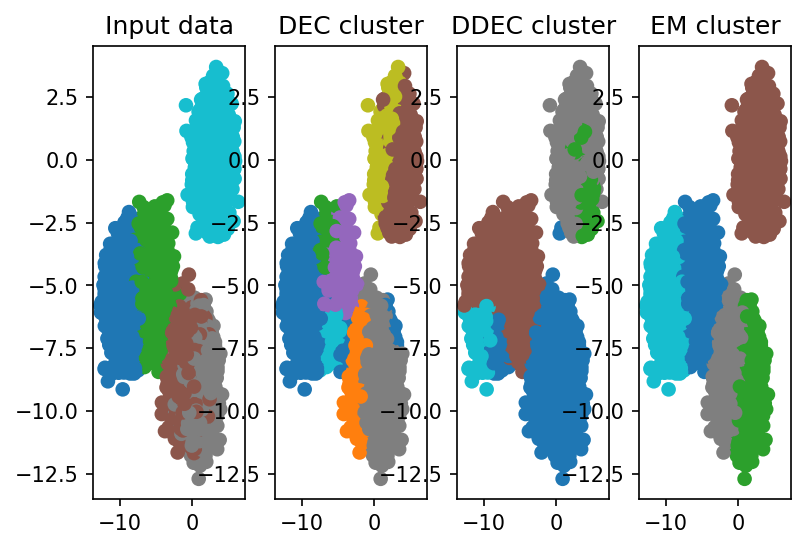

In [17]:
fig, axs = plt.subplots(ncols=4, dpi=150)

axs[0].scatter(X[0], X[1], c=y, cmap='tab10')
axs[0].set_title('Input data')

axs[1].scatter(X[0], X[1], c=sdec_preds, cmap='tab10')
axs[1].set_title('DEC cluster')

axs[2].scatter(X[0], X[1], c=ddec_preds, cmap='tab10')
axs[2].set_title('DDEC cluster')

axs[3].scatter(X[0], X[1], c=em_preds, cmap='tab10')
axs[3].set_title('EM cluster')

plt.show()
plt.close(fig)

## Execution time

In [18]:
execution_times = np.array(sorted([[sdec_time, 'SDEC'], [ddec_time, 'DDEC'], [em_time, 'EM']]))

<AxesSubplot:>

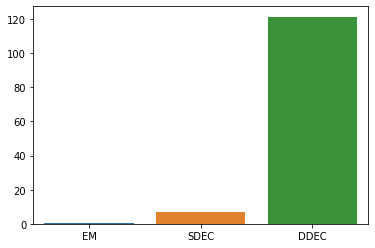

In [19]:
sns.barplot(x=execution_times[:,1], y=execution_times[:,0].astype(np.float))

## Comparative analysis between em and standard DEC 

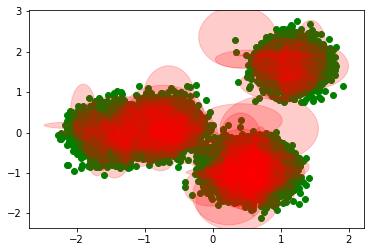

ARI: 0.5769691477586659


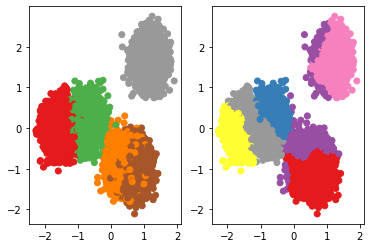

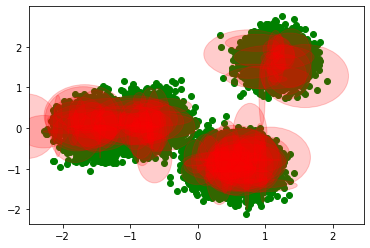

ARI: 0.6345599244714236


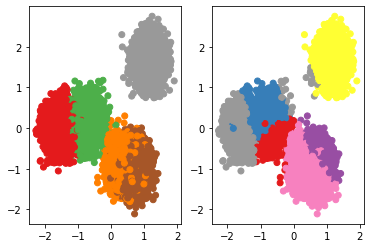

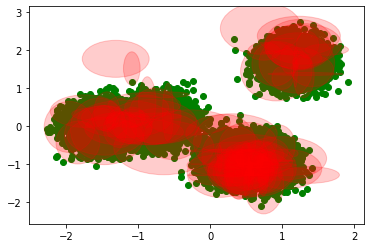

ARI: 0.5391610726576762


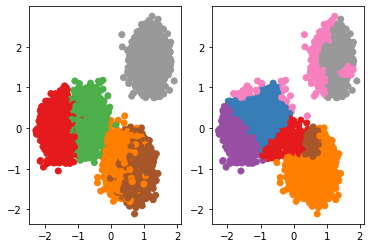

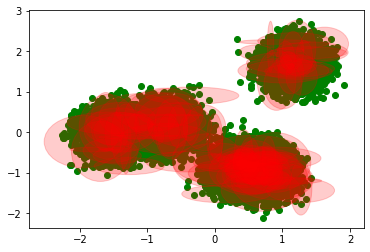

ARI: 0.4805143405134233


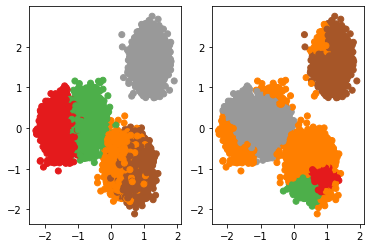

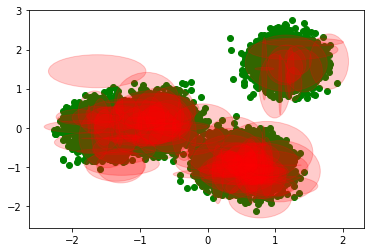

ARI: 0.47922981123818154


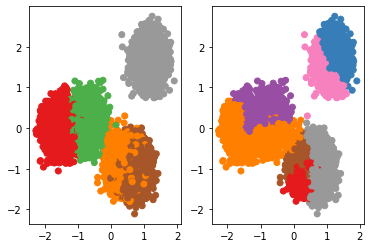

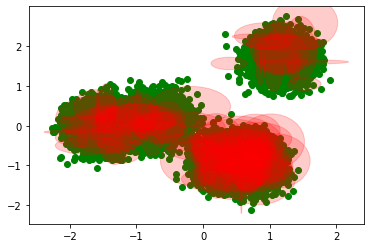

ARI: 0.534682248852263


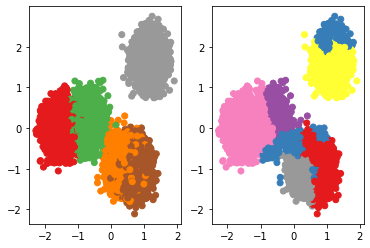

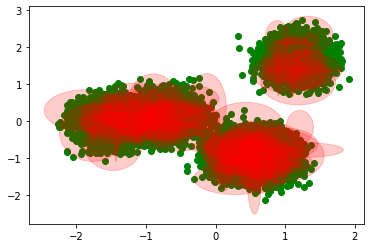

ARI: 0.3568127701675127


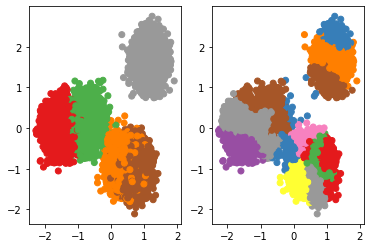

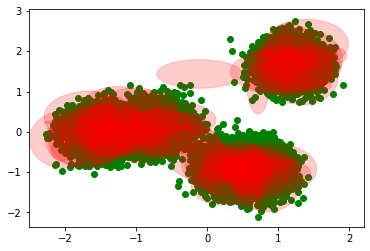

ARI: 0.5457961919472492


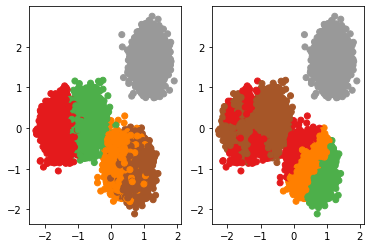

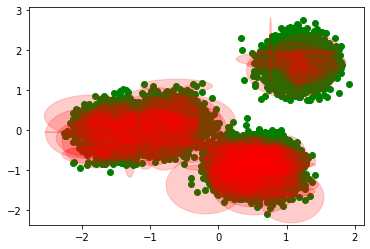

ARI: 0.5532182644375689


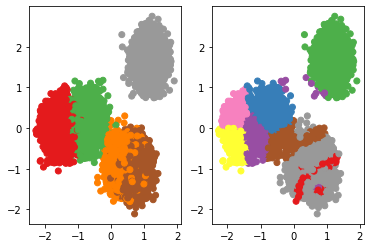

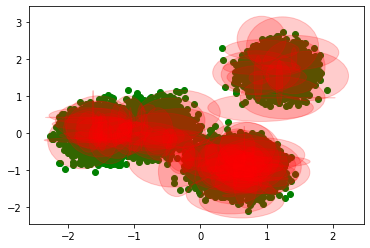

ARI: 0.513168807166909


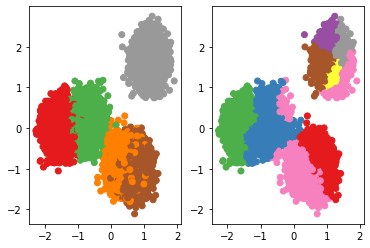

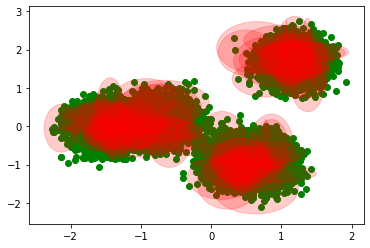

ARI: 0.483948950221069


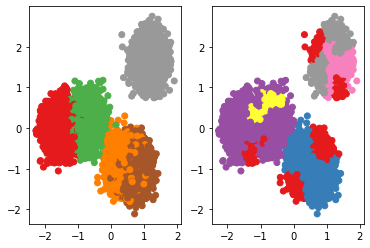

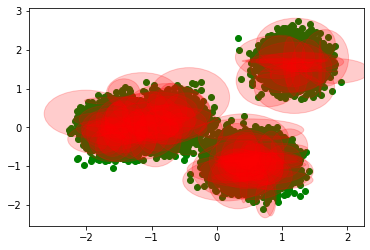

ARI: 0.519258895098229


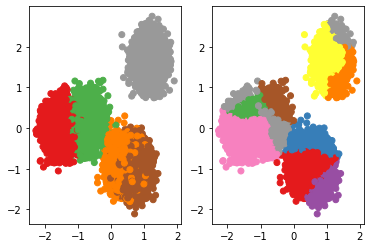

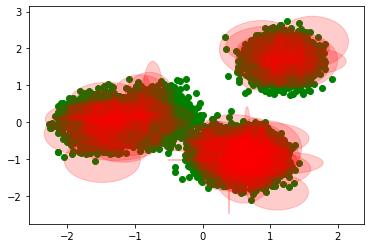

ARI: 0.5666038423504975


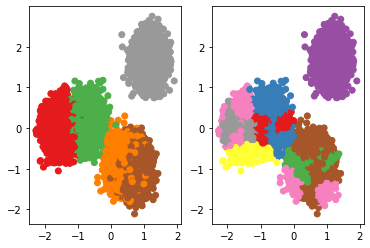

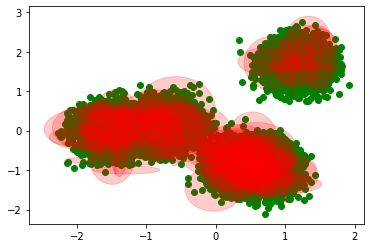

ARI: 0.5651790802063712


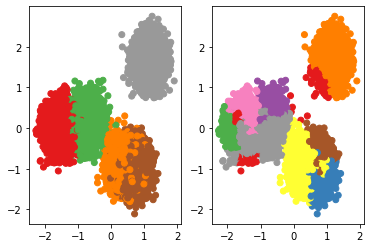

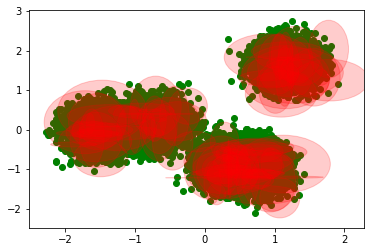

ARI: 0.6257219407008194


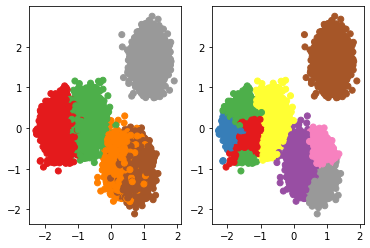

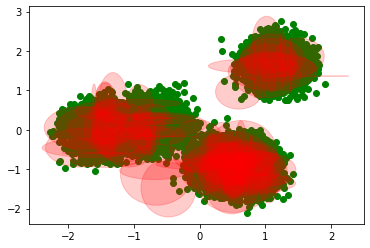

ARI: 0.7085941061190981


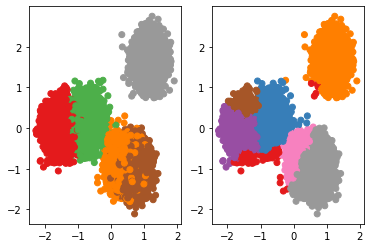

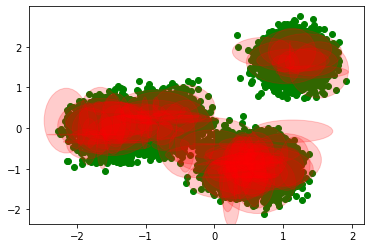

ARI: 0.6254176124694485


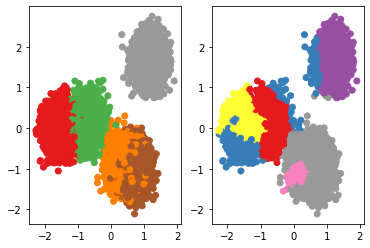

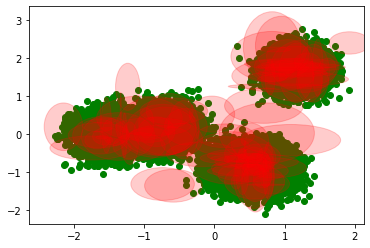

ARI: 0.6664135785732912


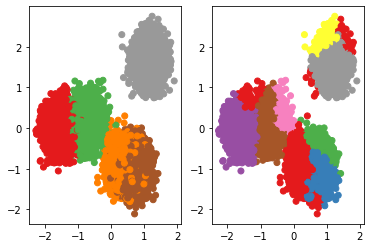

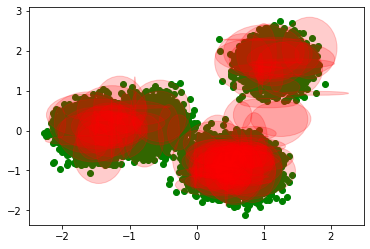

ARI: 0.4196126615526069


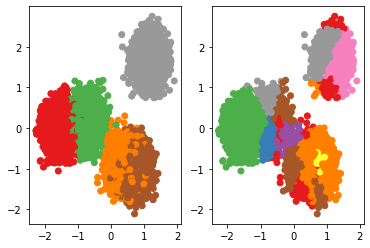

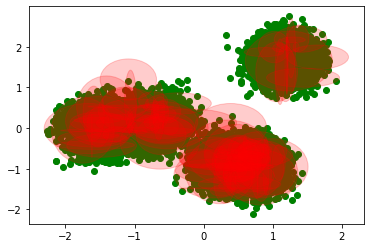

ARI: 0.5656100006997027


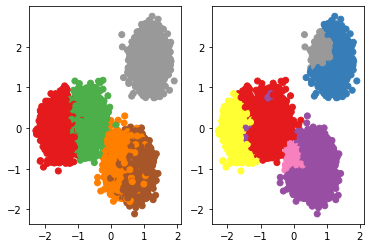

In [20]:
sdec_predictions = []
em_predictions = []

for _ in range(20):
    sdec_preds = sdec.differential_clustering(scaler.transform(X), y, N_ITER, crowding=True, smart_init=False, wait_on_plots=False, verbose=False)
    gm = em.gaussian_mixture(X, n_clusters=y.max()+1)
    em_preds = gm.predict(X)
    
    sdec_predictions.append(sdec_preds)
    em_predictions.append(em_preds)

In [21]:
em_v_scores = []
sdec_v_scores = []

em_ari_scores = []
sdec_ari_scores = []

for alg, predictions, ari_scores, v_scores in [('EM', em_predictions, em_ari_scores, em_v_scores), ('DEC', sdec_predictions, sdec_ari_scores, sdec_v_scores)]:
    # each cluster contains only members of a single class.
    print(f"Homogeneity score mean - {alg}:", sum([metrics.homogeneity_score(y, prediction) for prediction in predictions])/20)
    
    # all members of a given class are assigned to the same cluster.
    print(f"Completeness score mean - {alg}:", sum([metrics.completeness_score(y, prediction) for prediction in predictions])/20)
    
    # harmonic mean between homogeneity score and completness score
    _v_scores = [metrics.v_measure_score(y, prediction) for prediction in predictions]
    v_scores.append(_v_scores)
    print(f"V score mean - {alg}:", sum(_v_scores)/20)
    
    # measures the similarity of the two assignments
    _ari_scores = [metrics.adjusted_rand_score(y, prediction) for prediction in predictions]
    ari_scores.append(_ari_scores)
    print(f"ARI mean - {alg}:", sum(_ari_scores)/20)
    print("")
    
scores = pd.DataFrame()
scores["em_v_score"] = em_v_scores[0]
scores["sdec_v_score"] = sdec_v_scores[0]
scores["em_ari_score"] = em_ari_scores[0]
scores["sdec_ari_score"] = sdec_ari_scores[0]

Homogeneity score mean - EM: 0.8049611723328113
Completeness score mean - EM: 0.8428714024970894
V score mean - EM: 0.8230456483037178
ARI mean - EM: 0.7385513009639356

Homogeneity score mean - DEC: 0.7162092021702292
Completeness score mean - DEC: 0.6503325632531484
V score mean - DEC: 0.6785572460592721
ARI mean - DEC: 0.5480236623601002



In [22]:
scores.describe()

,em_v_score,sdec_v_score,em_ari_score,sdec_ari_score
count,20.000000,20.000000,20.000000,20.000000
mean,0.823046,0.678557,0.738551,0.548024
std,0.002998,0.053497,0.047243,0.082678
min,0.819992,0.580376,0.684603,0.356813
25%,0.820388,0.650113,0.690901,0.505864
50%,0.822531,0.679206,0.745735,0.549507
75%,0.822977,0.716437,0.784098,0.589081
max,0.829916,0.794715,0.785007,0.708594


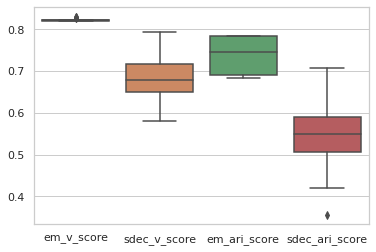

In [23]:
sns.set_theme(style="whitegrid")

ax = sns.boxplot(data=scores)